In [33]:
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['savefig.dpi'] = 300 

In [21]:
output = pd.read_csv("output/detected_copulars.csv")

In [22]:
output["invariant_be"] = output.target.str.contains("be$", regex=True)

In [23]:
columns_to_use = [
    'Age', # used to create unified age cohorts
    'Age.Group', # original age cohorts, depends on corpus
    'Gender',
    'Other.Places.Lived',
    'Year.of.Birth',
    'Year.of.Interview',
    'region_id',
    'speaker_id',
    'source_file'
]

# Procure metadata
metadata = dict()
for f in glob("data/*_metadata_*.txt"):
    curr = pd.read_csv(f, sep="\t", dtype ={'Age.Group': str})
    # Assign region ID
    curr["region_id"] = os.path.basename(f)[0:3]
    
    # Filter by relevant speakers
    curr = curr.loc[curr['CORAAL.Spkr'].isin(output.speaker_id.tolist())]

    curr = curr.rename(
        columns={
            'CORAAL.Spkr': 'speaker_id',
            'CORAAL.File': 'source_file'
        }
    )
    # Filter by relevant columns
    metadata[f] = curr[columns_to_use]

# Flatten metadata and generate new age cohorts
spkr_df = pd.concat(metadata.values())

# Merge metadata content onto quotative productions
df = output.merge(
    spkr_df,
    on=['source_file', 'speaker_id', 'region_id'],
    how='left'
)

# Check if any rows failed to merge
initial_matches = df[columns_to_use[0]].notna().sum()
print(f"  - Failed to match: {len(df) - initial_matches} rows\n")

# Identify speaker_ids that need fallback
needs_fallback = df[df[columns_to_use[0]].isna()]['speaker_id'].unique()
print(f"  - {len(needs_fallback)} unique speaker_ids need fallback\n")

# For rows still missing demographics, do a fallback merge on speaker_id only
missing_mask = df[columns_to_use[0]].isna()

if missing_mask.any():
    # Get unique metadata for each speaker_id (keep first occurrence)
    metadata_lookup = spkr_df.drop_duplicates(
        subset='speaker_id', 
        keep='first'
    )
# For rows with missing data, look up by speaker_id
    missing_speakers = df.loc[missing_mask, 'speaker_id']
    fallback_data = missing_speakers.to_frame().merge(
        metadata_lookup,
        on='speaker_id',
        how='left'
    )
    
    # Fill in the missing demographic columns
    for col in columns_to_use:
        df.loc[missing_mask, col] = fallback_data[col].values

print(len(df))

  - Failed to match: 114 rows

  - 1 unique speaker_ids need fallback

16069


In [25]:
def get_age_cohort(age):
    if age < 29:
        return '-29'
    elif age > 50:
        return '51+'
    else:
        return '30-50'   

# Create age cohorts
def assign_age_group(age):
    if age <= 12:
        return "9-12"
    elif age >=13 and age <=16:
        return "13-16"
    elif age >=17 and age <=29:
        return "17-29"
    elif age >=30 and age <=39:
        return "30-39"
    elif age >=40 and age <=49:
        return "40-49"
    elif age >=50 and age <=59:
        return "50-59"
    elif age >=60:
        return "60+"
    else:
        return None
        
# Create age cohorts
def assign_cohort(year_of_birth):
    if year_of_birth < 1941:
        return "Before 1941"
    if 1941 <= year_of_birth <= 1960:
        return "Cohort 1\n1941-60"
    elif 1961 <= year_of_birth <= 1977:
        return "Cohort 2\n1961-77"
    elif 1978 <= year_of_birth <= 1990:
        return "Cohort 3\n1978-90"
    elif 1991 <= year_of_birth <= 2002:
        return "Cohort 4\n1991-2002"
    elif year_of_birth > 2002:
        return "After 2002"

# Assign age cohorts in 3 ways
# unified given CORAAL conventions
df['Age.Cohort'] = df['Age'].apply(get_age_cohort)
# based on T&D (2009)
df['age_group'] = df['Age'].apply(assign_age_group)
# based on Cukor-Avila (2012)
df['cohort'] = df['Year.of.Birth'].apply(assign_cohort)

In [41]:
# Count unique speakers per cohort
speaker_counts = df.groupby('cohort')['speaker_id'].nunique() 

# Get groups with at least 5 speakers
group_order = sorted(speaker_counts[speaker_counts >= 5].index.tolist())

# Filter your dataframe
df_grouped = df[df['cohort'].isin(group_order)]

In [27]:
region_order = [
    "ATL",
    "DCB",
    "ROC",
    "VLD",
    "PRV",
    "LES"
]

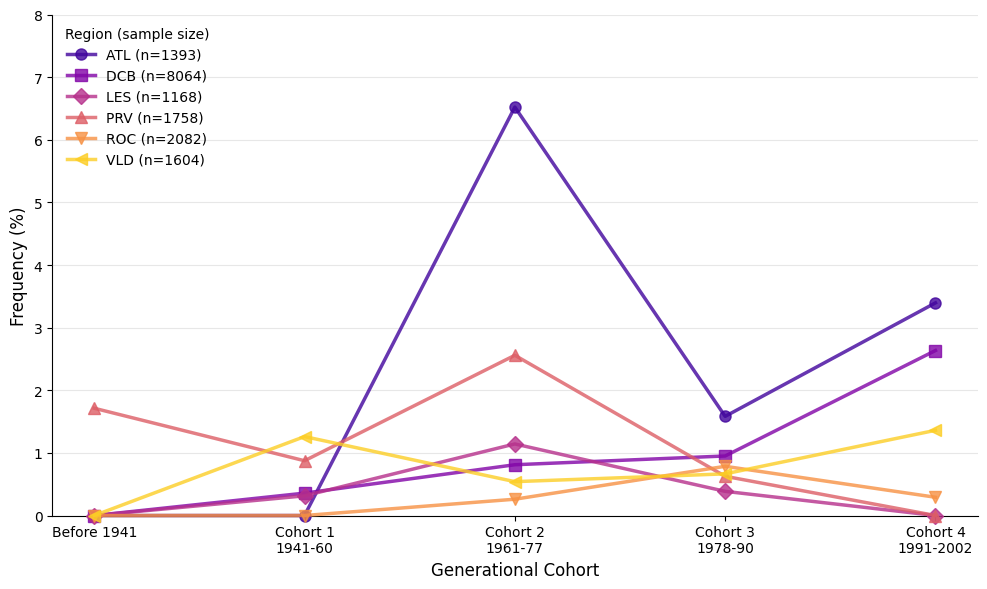

In [46]:
# Calculate invariant be counts and total counts by age group and region
age_region_invariant = df_grouped.groupby(['cohort', 'region_id'])['invariant_be'].sum()
age_region_total = df_grouped.groupby(['cohort', 'region_id']).size()

# Calculate percentages
age_region_percentages = (age_region_invariant / age_region_total * 100).unstack(fill_value=0)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique regions and generate colors
region_list = sorted(age_region_percentages.columns)
region_colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(region_list)))

# Define markers for variety
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

# Set spine properties
ax.spines['bottom'].set_zorder(0)
ax.spines['left'].set_zorder(0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Get age group order (sorted)
age_order = sorted(age_region_percentages.index)

# Get sample sizes for each region (for legend)
region_sizes = df.groupby('region_id').size()

# Plot lines for each region
for i, region in enumerate(region_list):
    if region in age_region_percentages.columns:
        n = region_sizes.get(region, 0)
        ax.plot(
            age_order,
            age_region_percentages.loc[age_order, region],
            label=f'{region} (n={n})',
            marker=markers[i % len(markers)],
            linewidth=2.5,
            markersize=8,
            color=region_colors[i],
            zorder=10,
            clip_on=False,
            alpha=0.8
        )

# Formatting
ax.set_axisbelow(True)
ax.set_ylim(0, 8)  # Set reasonable fixed limit given your data
ax.set_xlabel('Generational Cohort', fontsize=12)
ax.set_ylabel('Frequency (%)', fontsize=12)
ax.legend(loc='upper left', fontsize=10, frameon=False, title='Region (sample size)')
ax.grid(axis='y', alpha=0.3, zorder=1)

plt.tight_layout()
plt.savefig('viz/invariant_be_age_region.png')
# plt.show()